In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
import holidays

def fill_missing_hour_station(df, time_col, station_cols, count_col):
    df[time_col] = pd.to_datetime(df[time_col])
    full_hours = pd.date_range(start=df[time_col].min(), end=df[time_col].max(), freq="H")
    all_stations = df[station_cols].drop_duplicates()

    full_combinations = pd.DataFrame([
        [hour] + list(station) for hour in full_hours for station in all_stations.values
    ], columns=[time_col] + station_cols)

    merged = pd.merge(full_combinations, df, on=[time_col] + station_cols, how="left")
    merged[count_col] = merged[count_col].fillna(0).astype(int)
    return merged

def to_new_york(series):
    if pd.api.types.is_datetime64tz_dtype(series):
        return series.dt.tz_convert("America/New_York")
    else:
        return series.dt.tz_localize("UTC", ambiguous='NaT', nonexistent='shift_forward').dt.tz_convert("America/New_York")

def map_time_of_day(hour):
    if 0 <= hour <= 5:
        return "Night"
    elif 6 <= hour <= 11:
        return "Morning"
    elif 12 <= hour <= 17:
        return "Afternoon"
    else:
        return "Evening"

def transform_to_timeseries(input_dir="../data/processed/validated", output_dir="../data/processed/timeseries"):
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    for file in sorted(input_path.glob("rides_*.parquet")):
        print(f"\n🔁 Transforming: {file.name}")
        try:
            df = pd.read_parquet(file)
        except Exception as e:
            print(f"⚠️ Failed to read {file.name}: {e}")
            continue
        
        # Convert timestamps safely
        df["started_at"] = to_new_york(pd.to_datetime(df["started_at"], errors="coerce"))
        df["ended_at"] = to_new_york(pd.to_datetime(df["ended_at"], errors="coerce"))

        # Convert start_station_id to int (✅ added here)
        if "start_station_id" in df.columns:
            df["start_station_id"] = pd.to_numeric(df["start_station_id"], errors="coerce").dropna().astype(int)

        # Drop any rows with invalid or missing timestamps
        df = df.dropna(subset=["started_at", "ended_at"])

        # ✅ FINAL DST FIX
        df = df[~((df["started_at"].dt.month == 11) & 
                  (df["started_at"].dt.day == 3) & 
                  (df["started_at"].dt.hour == 1))]

        # Floor to hour
        df["hour_ts"] = df["started_at"].dt.floor("H")
        year_detected = df["hour_ts"].dt.year.max()

        # Create US holidays for detected year
        us_holidays = holidays.US(years=[year_detected])

        # Group
        grouped = df.groupby(["start_station_name", "start_station_id", "hour_ts"]).size().reset_index(name="ride_count")
        grouped = fill_missing_hour_station(grouped, "hour_ts", ["start_station_name", "start_station_id"], "ride_count")
        
        # === Feature Engineering ===
        grouped["hour"] = grouped["hour_ts"].dt.hour
        grouped["hour_sin"] = np.sin(2 * np.pi * grouped["hour"] / 24)
        grouped["hour_cos"] = np.cos(2 * np.pi * grouped["hour"] / 24)
        grouped["day_of_week"] = grouped["hour_ts"].dt.dayofweek
        
        is_weekend = (grouped["day_of_week"] >= 5).astype(int)
        is_holiday = pd.to_datetime(grouped["hour_ts"].dt.date).isin(us_holidays).astype(int)

        grouped["is_holiday_or_weekend"] = ((is_weekend + is_holiday) >= 1).astype(int)
        grouped["month"] = grouped["hour_ts"].dt.month
        grouped["is_peak_hour"] = grouped["hour"].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)
        grouped["day_of_year"] = grouped["hour_ts"].dt.dayofyear
        grouped["time_of_day"] = grouped["hour"].apply(map_time_of_day)
        
        # === Lag Features ===
        grouped = grouped.sort_values(["start_station_name", "hour_ts"])
        grouped["ride_count_lag_1"] = grouped.groupby("start_station_name")["ride_count"].shift(1)
        grouped["ride_count_roll3"] = grouped.groupby("start_station_name")["ride_count"].shift(1).rolling(3).mean()

        # === Remove rows where lag features are missing ===
        grouped = grouped.dropna(subset=["ride_count_lag_1", "ride_count_roll3"])

        # Save cleaned output
        output_file = output_path / file.name
        grouped.to_parquet(output_file, index=False)
        print(f"✅ Saved: {output_file} with {len(grouped)} rows (after cleaning)")

# Run the function
if __name__ == "__main__":
    transform_to_timeseries()



🔁 Transforming: rides_2024_01.parquet


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):


✅ Saved: ..\data\processed\timeseries\rides_2024_01.parquet with 3715 rows (after cleaning)

🔁 Transforming: rides_2024_02.parquet
✅ Saved: ..\data\processed\timeseries\rides_2024_02.parquet with 3470 rows (after cleaning)

🔁 Transforming: rides_2024_03.parquet


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDt

✅ Saved: ..\data\processed\timeseries\rides_2024_03.parquet with 3710 rows (after cleaning)

🔁 Transforming: rides_2024_04.parquet


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):


✅ Saved: ..\data\processed\timeseries\rides_2024_04.parquet with 3590 rows (after cleaning)

🔁 Transforming: rides_2024_05.parquet


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):


✅ Saved: ..\data\processed\timeseries\rides_2024_05.parquet with 3705 rows (after cleaning)

🔁 Transforming: rides_2024_06.parquet


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):


✅ Saved: ..\data\processed\timeseries\rides_2024_06.parquet with 3590 rows (after cleaning)

🔁 Transforming: rides_2024_07.parquet


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):


✅ Saved: ..\data\processed\timeseries\rides_2024_07.parquet with 3715 rows (after cleaning)

🔁 Transforming: rides_2024_08.parquet


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):


✅ Saved: ..\data\processed\timeseries\rides_2024_08.parquet with 3710 rows (after cleaning)

🔁 Transforming: rides_2024_09.parquet


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):


✅ Saved: ..\data\processed\timeseries\rides_2024_09.parquet with 3590 rows (after cleaning)

🔁 Transforming: rides_2024_10.parquet


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):


✅ Saved: ..\data\processed\timeseries\rides_2024_10.parquet with 3710 rows (after cleaning)

🔁 Transforming: rides_2024_11.parquet
✅ Saved: ..\data\processed\timeseries\rides_2024_11.parquet with 3590 rows (after cleaning)

🔁 Transforming: rides_2024_12.parquet


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDt

✅ Saved: ..\data\processed\timeseries\rides_2024_12.parquet with 3710 rows (after cleaning)

🔁 Transforming: rides_2025_01.parquet
✅ Saved: ..\data\processed\timeseries\rides_2025_01.parquet with 3710 rows (after cleaning)

🔁 Transforming: rides_2025_02.parquet


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDt

✅ Saved: ..\data\processed\timeseries\rides_2025_02.parquet with 3350 rows (after cleaning)

🔁 Transforming: rides_2025_03.parquet
✅ Saved: ..\data\processed\timeseries\rides_2025_03.parquet with 3710 rows (after cleaning)


C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):
C:\Users\MD\AppData\Local\Temp\ipykernel_16244\2168746239.py:20: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(series):


In [12]:
import pandas as pd
from pathlib import Path

# Path to your output directory and sample file
output_file = Path("../data/processed/timeseries/rides_2024_01.parquet")  # Change to any file you processed

# Load the saved parquet file
df_saved = pd.read_parquet(output_file)

# Print the first few rows
print("\n✅ Checking saved transformed data (First 5 rows):")
print(df_saved.head())

# Also print datatypes if needed
print("\n📋 Data types of saved columns:")
print(df_saved.dtypes)


print("\n🔍 Value counts for is_holiday:")
print(df_saved["is_holiday_or_weekend"].value_counts(dropna=False))


✅ Checking saved transformed data (First 5 rows):
                    hour_ts start_station_name  start_station_id  ride_count  \
0 2023-12-31 20:00:00-05:00    8 Ave & W 31 St              6450           9   
1 2023-12-31 21:00:00-05:00    8 Ave & W 31 St              6450           3   
2 2023-12-31 22:00:00-05:00    8 Ave & W 31 St              6450           0   
3 2023-12-31 23:00:00-05:00    8 Ave & W 31 St              6450           2   
4 2024-01-01 00:00:00-05:00    8 Ave & W 31 St              6450           0   

   hour  hour_sin  hour_cos  day_of_week  is_holiday_or_weekend  month  \
0    20 -0.866025  0.500000            6                      1     12   
1    21 -0.707107  0.707107            6                      1     12   
2    22 -0.500000  0.866025            6                      1     12   
3    23 -0.258819  0.965926            6                      1     12   
4     0  0.000000  1.000000            0                      1      1   

   is_peak_hour  day_of

In [13]:
import pandas as pd

# Load your parquet file
df = pd.read_parquet('../data/processed/timeseries/rides_2024_01.parquet')

# See basic info
print(df.info())

# See first few rows
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3715 entries, 0 to 3714
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype                           
---  ------                 --------------  -----                           
 0   hour_ts                3715 non-null   datetime64[ns, America/New_York]
 1   start_station_name     3715 non-null   object                          
 2   start_station_id       3715 non-null   int64                           
 3   ride_count             3715 non-null   int32                           
 4   hour                   3715 non-null   int32                           
 5   hour_sin               3715 non-null   float64                         
 6   hour_cos               3715 non-null   float64                         
 7   day_of_week            3715 non-null   int32                           
 8   is_holiday_or_weekend  3715 non-null   int32                           
 9   month                  3715 non-null   in

In [14]:
import pandas as pd
from pathlib import Path

# Load any processed monthly file you saved
saved_file = Path("../data/processed/timeseries/rides_2024_01.parquet")  # update file name if needed
df_saved = pd.read_parquet(saved_file)

# Check for missing values
print("\n🔎 Missing Value Check After Cleaning:")

missing_lag1 = df_saved["ride_count_lag_1"].isnull().sum()
missing_roll3 = df_saved["ride_count_roll3"].isnull().sum()

print(f"Missing ride_count_lag_1: {missing_lag1}")
print(f"Missing ride_count_roll3: {missing_roll3}")

if missing_lag1 == 0 and missing_roll3 == 0:
    print("\n✅ File is fully clean — no missing lags or rolling means!")
else:
    print("\n❗ Warning: Missing values still exist!")



🔎 Missing Value Check After Cleaning:
Missing ride_count_lag_1: 0
Missing ride_count_roll3: 0

✅ File is fully clean — no missing lags or rolling means!


In [15]:
print("\n🔎 Quick Health Check:")

print(f"Total rows: {len(df_saved):,}")
print(f"Total unique stations: {df_saved['start_station_name'].nunique()}")
print(f"Min ride_count: {df_saved['ride_count'].min()}, Max ride_count: {df_saved['ride_count'].max()}")
print(f"Hours covered: {df_saved['hour_ts'].min()} ➔ {df_saved['hour_ts'].max()}")
print(f"Missing ride_count_lag_1: {df_saved['ride_count_lag_1'].isna().sum()} rows")
print(f"Missing ride_count_roll3: {df_saved['ride_count_roll3'].isna().sum()} rows")

print("\n🚲 Ride Count Statistics:")
print(df_saved["ride_count"].describe())



🔎 Quick Health Check:
Total rows: 3,715
Total unique stations: 5
Min ride_count: 0, Max ride_count: 50
Hours covered: 2023-12-31 20:00:00-05:00 ➔ 2024-01-31 18:00:00-05:00
Missing ride_count_lag_1: 0 rows
Missing ride_count_roll3: 0 rows

🚲 Ride Count Statistics:
count    3715.000000
mean        8.021534
std         8.703150
min         0.000000
25%         1.000000
50%         5.000000
75%        12.000000
max        50.000000
Name: ride_count, dtype: float64


C:\Users\MD\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


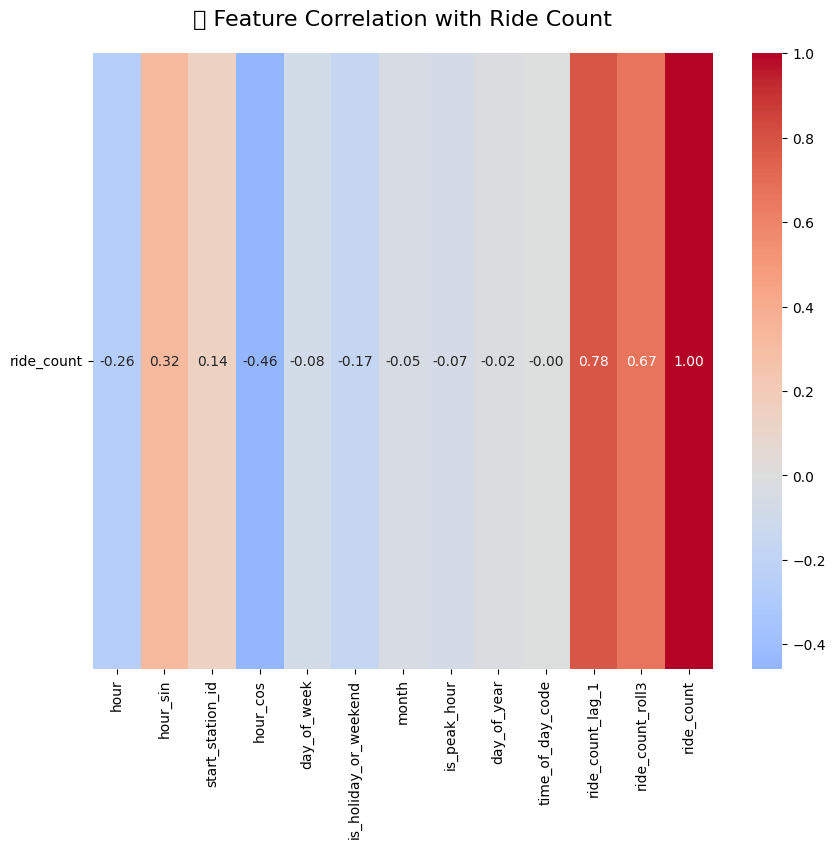

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Load your latest processed file
file = Path("../data/processed/timeseries/rides_2024_01.parquet")
df = pd.read_parquet(file)

# List of features
feature_cols = [
    'hour', 'hour_sin', 'start_station_id', 'hour_cos', 'day_of_week', 'is_holiday_or_weekend', 
    'month', 'is_peak_hour', 'day_of_year', 'time_of_day',
    'ride_count_lag_1', 'ride_count_roll3'
]

# Handle time_of_day separately
if "time_of_day" in df.columns:
    df["time_of_day_code"] = df["time_of_day"].astype("category").cat.codes
    feature_cols = [col if col != "time_of_day" else "time_of_day_code" for col in feature_cols]

# Handle start_station_id (if it's object type)
if df["start_station_id"].dtype == "object":
    df["start_station_id_encoded"] = df["start_station_id"].astype("category").cat.codes
    feature_cols = [col if col != "start_station_id" else "start_station_id_encoded" for col in feature_cols]

# Select only the features + ride_count
selected_cols = feature_cols + ["ride_count"]
df_selected = df[selected_cols].dropna()

# Compute the correlation matrix
correlation_matrix = df_selected.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[["ride_count"]].T, 
            annot=True, cmap="coolwarm", center=0, fmt=".2f")

plt.title("🔍 Feature Correlation with Ride Count", fontsize=16, pad=20)
plt.yticks(rotation=0)
plt.show()


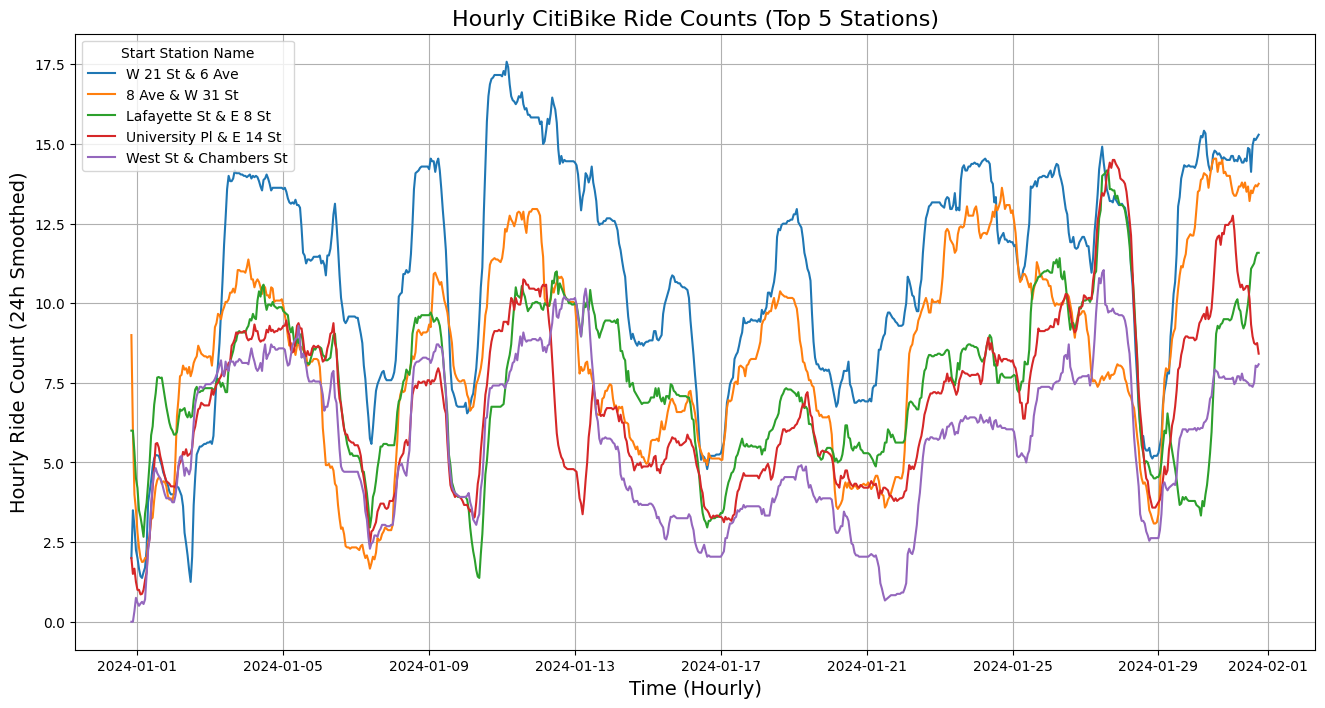

In [17]:
import matplotlib.pyplot as plt

def plot_top_stations(df, top_n=3):
    """
    Plots ride counts over time for the top N start stations.
    """
    top_stations = (
        df.groupby("start_station_name")["ride_count"]
        .sum()
        .sort_values(ascending=False)
        .head(top_n)
        .index
    )

    plt.figure(figsize=(16, 8))
    for station in top_stations:
        station_data = df[df["start_station_name"] == station]
        station_data = station_data.set_index("hour_ts").sort_index()
        
        # Optional: smooth using 24h rolling average
        station_data["ride_count_rolling"] = station_data["ride_count"].rolling(window=24, min_periods=1).mean()
        
        plt.plot(station_data.index, station_data["ride_count_rolling"], label=station)

    plt.xlabel("Time (Hourly)", fontsize=14)
    plt.ylabel("Hourly Ride Count (24h Smoothed)", fontsize=14)
    plt.title(f"Hourly CitiBike Ride Counts (Top {top_n} Stations)", fontsize=16)
    plt.legend(title="Start Station Name")
    plt.grid(True)
    plt.show()

# Example usage:
# Load one month timeseries file you already saved
month = 1
year = 2024
df = pd.read_parquet(f'../data/processed/timeseries/rides_{year}_{month:02d}.parquet')

# Plot top 3 stations
plot_top_stations(df, top_n=5)


In [18]:
import matplotlib.pyplot as plt
from pathlib import Path

def plot_and_save_top_stations(df, year, month, output_dir="plots", top_n=3):
    """
    Plots and saves ride counts over time for the top N start stations for a month.
    """
    # Create output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Find top N stations by total rides
    top_stations = (
        df.groupby("start_station_name")["ride_count"]
        .sum()
        .sort_values(ascending=False)
        .head(top_n)
        .index
    )

    # Plot
    plt.figure(figsize=(16, 8))
    for station in top_stations:
        station_data = df[df["start_station_name"] == station]
        station_data = station_data.set_index("hour_ts").sort_index()
        
        # 24-hour rolling mean smoothing
        station_data["ride_count_rolling"] = station_data["ride_count"].rolling(window=24, min_periods=1).mean()
        
        plt.plot(station_data.index, station_data["ride_count_rolling"], label=station)

    plt.xlabel("Time (Hourly)", fontsize=14)
    plt.ylabel("Hourly Ride Count (24h Smoothed)", fontsize=14)
    plt.title(f"CitiBike Ride Counts - Top {top_n} Stations ({year}-{month:02})", fontsize=16)
    plt.legend(title="Start Station Name")
    plt.grid(True)

    # Save plot
    filename = output_path / f"rides_{year}_{month:02}_top{top_n}stations.png"
    plt.savefig(filename)
    plt.close()

    print(f"✅ Saved plot: {filename}")

# === Example usage ===

# List of months you have saved
months = [
    (2024, 1), (2024, 2), (2024, 3), (2024, 4),
    (2024, 5), (2024, 6), (2024, 7), (2024, 8),
    (2024, 9), (2024, 10), (2024, 11), (2024, 12),
    (2025, 1), (2025, 2), (2025, 3)
]

# Path where your timeseries files are
timeseries_path = Path("../data/processed/timeseries")

# Loop over all months and create plots
for year, month in months:
    file_path = timeseries_path / f"rides_{year}_{month:02}.parquet"
    if file_path.exists():
        df_month = pd.read_parquet(file_path)
        plot_and_save_top_stations(df_month, year, month)
    else:
        print(f"⚠️ File missing: {file_path}")


✅ Saved plot: plots\rides_2024_01_top3stations.png
✅ Saved plot: plots\rides_2024_02_top3stations.png
✅ Saved plot: plots\rides_2024_03_top3stations.png
✅ Saved plot: plots\rides_2024_04_top3stations.png
✅ Saved plot: plots\rides_2024_05_top3stations.png
✅ Saved plot: plots\rides_2024_06_top3stations.png
✅ Saved plot: plots\rides_2024_07_top3stations.png
✅ Saved plot: plots\rides_2024_08_top3stations.png
✅ Saved plot: plots\rides_2024_09_top3stations.png
✅ Saved plot: plots\rides_2024_10_top3stations.png
✅ Saved plot: plots\rides_2024_11_top3stations.png
✅ Saved plot: plots\rides_2024_12_top3stations.png
✅ Saved plot: plots\rides_2025_01_top3stations.png
✅ Saved plot: plots\rides_2025_02_top3stations.png
✅ Saved plot: plots\rides_2025_03_top3stations.png


In [10]:
df_month.shape


(1664590, 15)